X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female).

X3: education (1 = graduate school; 2 = university; 3 = high school; 0, 4, 5, 6 = others).

X4: Marital status (1 = married; 2 = single; 3 = divorce; 0=others).

X5: age (year).

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. 

The measurement scale for the repayment status is:
-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.

X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

Y: client's behavior; Y=0 then not default, Y=1 then default"


In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff 
%matplotlib inline 

import gc

from datetime import datetime 
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample 
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier ,ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from scipy.stats import randint as sp_randint
from plotly.subplots import make_subplots
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,f1_score,roc_auc_score,roc_curve,accuracy_score
import warnings
warnings.filterwarnings("ignore")

pd.set_option('precision', 2)
pd.set_option('display.max_columns', 50)


In [21]:
# Import df

df = pd.read_csv("default of credit card clients.csv")
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2       3913       3102        689          0          0   
1      0      2       2682       1725       2682       3272       3455   
2      0      0      29239      14027      13559      14331      14948   
3      0      0      46990      48233      49291      28314      28959   
4      0      0       8617       5670      35835      20940      19146   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  dpnm  
0          0         0       689         0         0         0         0     1  
1       3261         0      1000      1000      1000         0      2000     1  
2      15549      1518      1500      1000      1000      1000      5000     0  
3      29547      2000      2019      1200      1100      1069      1000     0  
4      19131      2000     36681     10000      9000       689       679     0

In [22]:
# Check df

df.info()
# 30000 rows and 25columns without missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

In [23]:
# drop column "ID"

df.drop('ID', axis = 1, inplace =True) 

In [24]:
# Rename the columns
df.rename(columns={'LIMIT_BAL': 'credit_limit',
                   'SEX': 'gender',
                   'EDUCATION' : 'education',
                   'MARRIAGE' : 'marital_status',
                   'AGE' : 'age',
                   'PAY_1': 'payment_status_sept',
                   'PAY_2': 'payment_status_aug',
                   'PAY_3': 'payment_status_jul',
                   'PAY_4': 'payment_status_jun',
                   'PAY_5': 'payment_status_may',
                   'PAY_6': 'payment_status_apr',
                   'BILL_AMT1': 'bill_sept',
                   'BILL_AMT2': 'bill_aug',
                   'BILL_AMT3': 'bill_jul',
                   'BILL_AMT4': 'bill_jun',
                   'BILL_AMT5': 'bill_may',
                   'BILL_AMT6': 'bill_apr',
                   'PAY_AMT1': 'payment_amount_sept',
                   'PAY_AMT2': 'payment_amount_aug',
                   'PAY_AMT3': 'payment_amount_jul',
                   'PAY_AMT4': 'payment_amount_jun',
                   'PAY_AMT5': 'payment_amount_may',
                   'PAY_AMT6': 'payment_amount_apr',
                   'dpnm' : 'default_payment'}, inplace=True)


In [25]:
# Variables description

df.describe()

credit_limit    gender  education  marital_status       age  \
count      30000.00  30000.00   30000.00        30000.00  30000.00   
mean      167484.32      1.60       1.85            1.55     35.49   
std       129747.66      0.49       0.79            0.52      9.22   
min        10000.00      1.00       0.00            0.00     21.00   
25%        50000.00      1.00       1.00            1.00     28.00   
50%       140000.00      2.00       2.00            2.00     34.00   
75%       240000.00      2.00       2.00            2.00     41.00   
max      1000000.00      2.00       6.00            3.00     79.00   

       payment_status_sept  payment_status_aug  payment_status_jul  \
count             30000.00            30000.00            30000.00   
mean                 -0.02               -0.13               -0.17   
std                   1.12                1.20                1.20   
min                  -2.00               -2.00               -2.00   
25%                  -1.00               -1.00               -1.00   
50%                   0.00                0.00                0.00   
75%                   0.00                0.00                0.00   
max                   8.00                8.00                8.00   

       payment_status_jun  payment_status_may  payment_status_apr  bill_sept  \
count            30000.00            30000.00            30000.00   30000.00   
mean                -0.22               -0.27               -0.29   51223.33   
std                  1.17                1.13                1.15   73635.86   
min                 -2.00               -2.00               -2.00 -165580.00   
25%                 -1.00               -1.00               -1.00    3558.75   
50%                  0.00                0.00                0.00   22381.50   
75%                  0.00                0.00                0.00   67091.00   
max                  8.00                8.00                8.00  964511.00   

        bill_aug  bill_jul   bill_jun   bill_may   bill_apr  \
count   30000.00  3.00e+04   30000.00   30000.00   30000.00   
mean    49179.08  4.70e+04   43262.95   40311.40   38871.76   
std     71173.77  6.93e+04   64332.86   60797.16   59554.11   
min    -69777.00 -1.57e+05 -170000.00  -81334.00 -339603.00   
25%      2984.75  2.67e+03    2326.75    1763.00    1256.00   
50%     21200.00  2.01e+04   19052.00   18104.50   17071.00   
75%     64006.25  6.02e+04   54506.00   50190.50   49198.25   
max    983931.00  1.66e+06  891586.00  927171.00  961664.00   

       payment_amount_sept  payment_amount_aug  payment_amount_jul  \
count             30000.00            3.00e+04            30000.00   
mean               5663.58            5.92e+03             5225.68   
std               16563.28            2.30e+04            17606.96   
min                   0.00            0.00e+00                0.00   
25%                1000.00            8.33e+02              390.00   
50%                2100.00            2.01e+03             1800.00   
75%                5006.00            5.00e+03             4505.00   
max              873552.00            1.68e+06           896040.00   

       payment_amount_jun  payment_amount_may  payment_amount_apr  \
count            30000.00            30000.00            30000.00   
mean              4826.08             4799.39             5215.50   
std              15666.16            15278.31            17777.47   
min                  0.00                0.00                0.00   
25%                296.00              252.50              117.75   
50%               1500.00             1500.00             1500.00   
75%               4013.25             4031.50             4000.00   
max             621000.00           426529.00           528666.00   

       default_payment  
count         30000.00  
mean              0.22  
std               0.42  
min               0.00  
25%               0.00  
50%               0.00  
75%               0.00  
max

There are 30,000 distinct credit card clients.

The average value for the amount of credit card limit is 167,484 with max value being 1M.

*******************
More than half of those clients graduating from university or graduate school.

Most of the clients are either marrined or single.
********
**** those quantiles, mean and std of Categorical variable have no meaning, they just tell you which class is the 25% of the total class , e.g. you have 4 level of education: 0,1,2,3. the min is 0, 25% is 1, 50% is 2 since categorical variable has no floating number (i.e.2.5) , 75% is 2 and max is 3.

The average age is 35.

## Exploratory df Analysis (EDA)

### Default Payment Next Month (Target Variable)

Text(0.5, 1.0, 'Default Credit Card Clients - Default Payment Next Month')

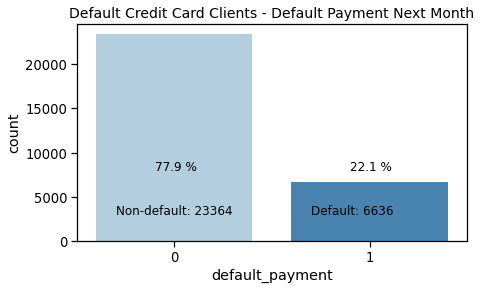

In [8]:
# The frequency of defaults
yes = df['default_payment'].sum()
no = len(df)-yes

# Percentage
yes_perc = round(yes/len(df)*100, 1)
no_perc = round(no/len(df)*100, 1)

plt.figure(figsize=(7,4))
sns.set_context('notebook', font_scale=1.2)
sns.countplot('default_payment',data=df, palette="Blues")
plt.annotate('Non-default: {}'.format(no), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
plt.annotate('Default: {}'.format(yes), xy=(0.7, 15000), xytext=(0.7, 3000), size=12)
plt.annotate(str(no_perc)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
plt.annotate(str(yes_perc)+" %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
plt.title('Default Credit Card Clients - Default Payment Next Month', size=14)

Around 78% of customer are not defaulted, only 22% of customer (6636 customers) have default payment the next month. The dataset is a little bit unbalanced.

### Distribution of Credit Limit

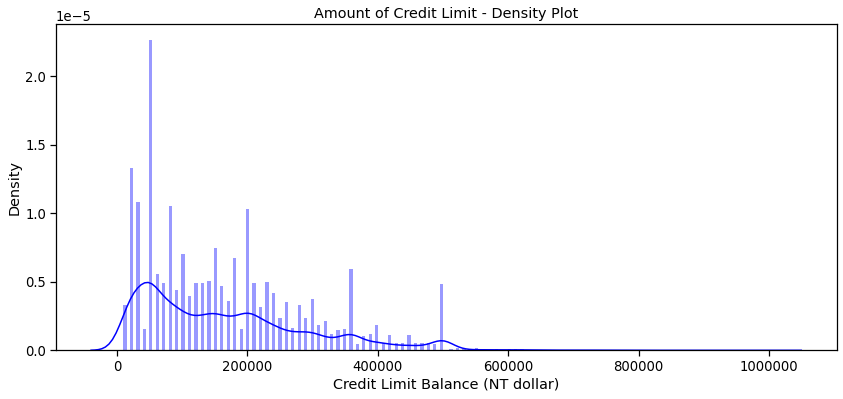

In [9]:
# Amount of credit limit

plt.figure(figsize = (14,6))
plt.title('Amount of Credit Limit - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(df["credit_limit"],kde=True,bins=200, color="blue")
plt.xlabel('Credit Limit Balance (NT dollar)')
plt.ticklabel_format(axis='x',scilimits = (0,1000000))
plt.show()

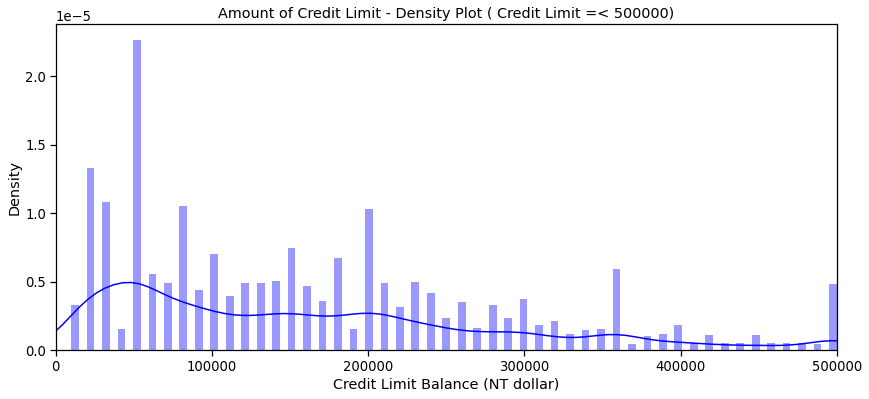

In [18]:
# Closer look to the amount of credit limit (exclude outliers)

plt.figure(figsize = (14,6))
plt.title('Amount of Credit Limit - Density Plot ( Credit Limit =< 500000)')
sns.set_color_codes("pastel")
sns.distplot(df["credit_limit"],kde=True,bins=200, color="blue")
plt.xlabel('Credit Limit Balance (NT dollar)')
plt.ticklabel_format(axis='x',scilimits = (0,500000))
plt.xlim(0,500000) 
plt.show()

In [10]:
# Largest group of amount of credit limit is for amount of 50K (3365 clients)

df['credit_limit'].value_counts().head(5)

50000     3365
20000     1976
30000     1610
80000     1567
200000    1528
Name: credit_limit, dtype: int64

The distribution of the credit limit is **right-skewed**, meaning the credit limit of customers are usually lower than 200,000 TWD. Credit limit at 50000 TWD has the highest density among all the credit limit levels, followed by 20000 TWD credit limit. 200000 TWD credit limit reaches another peak after the credit limit at 80000 TWD. We can also see the pattern of the credit limit: for every 50000 TWD, the density is higher than the credit limit falls between <50000 TWD interval. **( errrr... I don't know how to explain this : e.g. 60000,140000 , etc are usully less denser than the multiple of 50000)**

### Credit Limit by Default Payment Next Month


Text(0.5, 1.0, 'Credit Limit Balance Histogram by Default Payment Next Month')

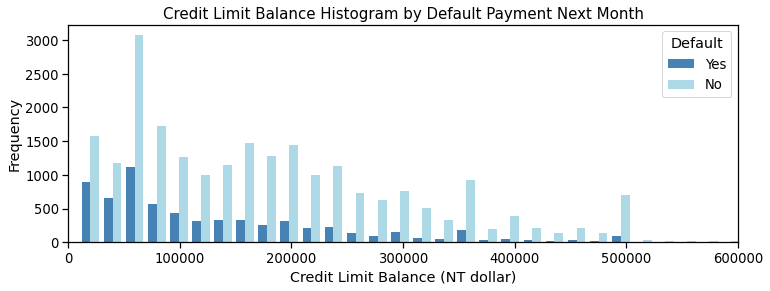

In [11]:
#Frequency of limit balance by default payment next month

x1 = list(df[df['default_payment'] == 1]['credit_limit'])
x2 = list(df[df['default_payment'] == 0]['credit_limit'])

plt.figure(figsize=(12,4))
sns.set_context('notebook', font_scale=1.2)
#sns.set_color_codes("pastel")
plt.hist([x1, x2], bins = 50, density=False, color=['steelblue', 'lightblue'])
plt.xlim([0,600000])
plt.legend(['Yes', 'No'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('Credit Limit Balance (NT dollar)')
plt.ylabel('Frequency')
plt.title('Credit Limit Balance Histogram by Default Payment Next Month', size=15)

Both customers with default payments and customers with no default payments have similar right-skewed distribution of credit limit. **The lower the credit limit, the higher the chance of default payment.** For customers with credit limit **lower than 60000 TWD**, **over half** of them have **default payment**. The situation gets better when the credit limit increases from 60000 TWD, the default rate is down to one-third or even lower.

### Gender

In [13]:
# gender

# 1 : Male ; 2 : Female

gender_count = df['gender'].value_counts().reset_index().rename(columns={'index':'gender','gender':'count'})

# Percentage
gender_count['percentage'] = [round(gender_count.iloc[0,1]/len(df)*100, 1),round(gender_count.iloc[1,1]/len(df)*100, 1)]

gender_count

gender  count  percentage
0       2  18112        60.4
1       1  11888        39.6

In [19]:
fig = px.bar(gender_count, y='count', x='gender', text='percentage',color= 'gender',
            title = 'Count plot of Gender',            
            labels={ # replaces default labels by column name
                "gender": "Gender",  "count": "Count", "percentage": "Percentage"
            },
            color_discrete_map={ # replaces default color mapping by value
                "Male": "royalblue", "Female": "crimson"
            },
            template="simple_white"
            )

fig.update_layout(uniformtext_minsize = 8, uniformtext_mode = 'hide',showlegend = False)
fig.show()

60% of the credit card customers are female and 40% are male.

### Education Level

In [20]:
# education

edu_count = df['education'].value_counts().reset_index().rename(columns={'index':'index','education':'count'})
edu_count 

index  count
0      2  14030
1      1  10585
2      3   4917
3      5    280
4      4    123
5      6     51
6      0     14

In [24]:
# education

edu_count['index'][0] = 'University'
edu_count['index'][1] = 'Graduate School'
edu_count['index'][2] = 'High School'
edu_count['index'][3] = 'Unknown_5'
edu_count['index'][4] = 'Others'
edu_count['index'][5] = 'Unknown_6'
edu_count['index'][6] = 'Unknown_0'

fig = go.Figure(go.Bar(
    x = edu_count['index'],y = edu_count['count'],text = edu_count['count'],marker={'color': edu_count['count']}
    ,textposition = "outside"))
fig.update_layout(title_text='Distribution of Education Level',xaxis_title="Education Status",yaxis_title="Number of customers")
fig.show()



<ipython-input-24-30640ae2e9ec>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-30640ae2e9ec>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-30640ae2e9ec>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-30640ae2e9ec>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

Most of clients are from university or graduate school.
We have three unknown classes which have no explanation in the document, so we will group them into 'Others' later.

### Marital Status

In [25]:
# Marriage

marriage_count = df['marital_status'].value_counts().reset_index().rename(columns={'index':'class','marital_status':'count'})
marriage_count

class  count
0      2  15964
1      1  13659
2      3    323
3      0     54

In [26]:
# marital_status
marriage_count['class'][0] = 'Single'
marriage_count['class'][1] = 'Married'
marriage_count['class'][2] = 'Others'
marriage_count['class'][3] = 'Unknown'

fig = go.Figure(go.Bar(
    x = marriage_count['class'],y = marriage_count['count'],text = marriage_count['count'],marker={'color': marriage_count['count']}
    ,textposition = "outside"))
fig.update_layout(title_text='Count plot of Marital Status',xaxis_title="Marital Status",yaxis_title="Number of count")
fig.show()

<ipython-input-26-24d158092960>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-24d158092960>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-24d158092960>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We have some unknown marital status which has no explanation from the document, so we will group them into 'Other' category later.

### Age

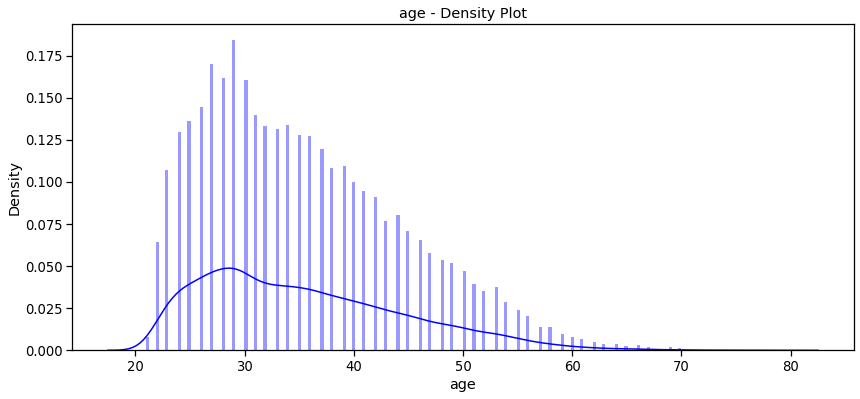

In [24]:
# age

plt.figure(figsize = (14,6))
plt.title('age - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(df["age"],kde=True,bins=200, color="blue")
plt.show()

# There are more clients who are aged between 20-30 and it goes on decreasing after 30

### Payment Status by Month

In [25]:
# History of past payment status

pay_s = df[['payment_status_sept','payment_status_aug', 'payment_status_jul', 'payment_status_jun', 'payment_status_may', 'payment_status_apr']]
df['payment_status_sept'].value_counts().index.to_list().sort()

fig = make_subplots(rows= 3, cols=2,subplot_titles=pay_s.columns.to_list())  

fig.add_trace(go.Histogram(x= df["payment_status_sept"],name='payment_status_sept'),row = 1, col = 1)
fig.add_trace(go.Histogram(x= df["payment_status_aug"],name='payment_status_aug'),row = 2, col = 2)
fig.add_trace(go.Histogram(x= df["payment_status_jul"],name='payment_status_jul'),row = 3, col = 1)
fig.add_trace(go.Histogram(x= df["payment_status_jun"],name='payment_status_jun'),row = 1, col = 2)
fig.add_trace(go.Histogram(x= df["payment_status_may"],name='payment_status_may'),row = 2, col = 1)
fig.add_trace(go.Histogram(x= df["payment_status_apr"],name='payment_status_apr'),row = 3, col = 2)


fig.update_layout(bargap=0.2,height=600, width=800, title_text="Histogram Subplots of Past Payment Status")
fig.show()

# Most of clients pay the previous amount duly but there're only some of them who pay late

### Correlation Matrix

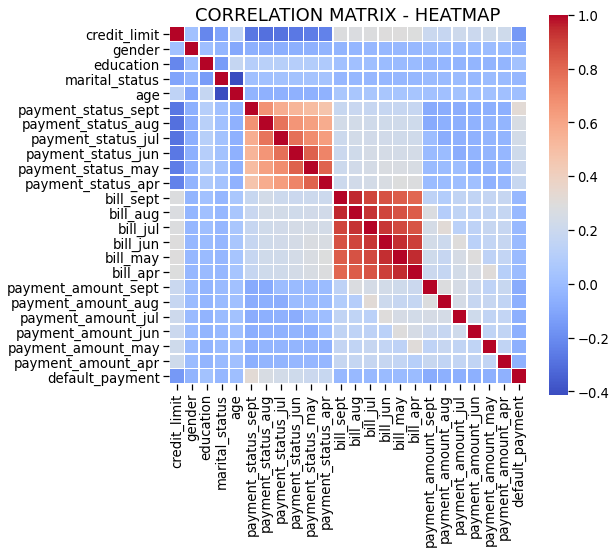

In [26]:
# Features correlation
corr = df.corr() # .corr is used to find corelation
f,ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('CORRELATION MATRIX - HEATMAP', size=18);

The variable "age" are highly correlated with "marital_status".

The only feature with a notable positive correlation with the dependent variable ‘default_payment’ is repayment status during the last month (September). 

** The highest negative correlation with default payment occurs with credit_limit, indicating that customers with lower limit balance are more likely to default.

### Further Exploration - Bivariate Analysis

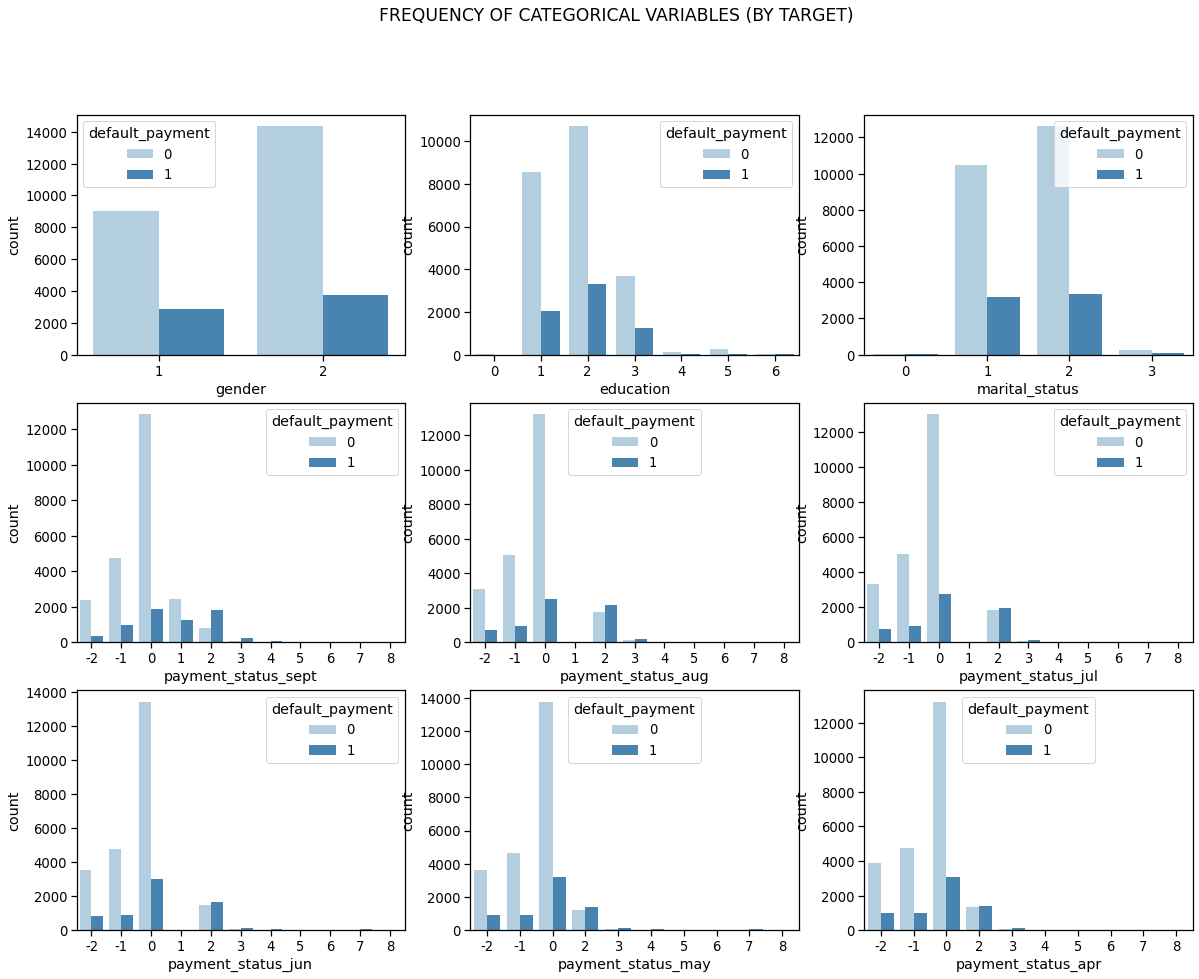

In [28]:
# Creating a new data frame with categorical variables

subset = df[['gender', 'education', 'marital_status', 'payment_status_sept','payment_status_aug',
             'payment_status_jul', 'payment_status_jun', 'payment_status_may', 'payment_status_apr','default_payment']]

f, axes = plt.subplots(3, 3, figsize=(20, 15), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)')
ax1 = sns.countplot(x="gender", hue="default_payment", data=subset, palette="Blues", ax=axes[0,0])
ax2 = sns.countplot(x="education", hue="default_payment", data=subset, palette="Blues",ax=axes[0,1])
ax3 = sns.countplot(x="marital_status", hue="default_payment", data=subset, palette="Blues",ax=axes[0,2])
ax4 = sns.countplot(x="payment_status_sept", hue="default_payment", data=subset, palette="Blues", ax=axes[1,0])
ax5 = sns.countplot(x="payment_status_aug", hue="default_payment", data=subset, palette="Blues", ax=axes[1,1])
ax6 = sns.countplot(x="payment_status_jul", hue="default_payment", data=subset, palette="Blues", ax=axes[1,2])
ax7 = sns.countplot(x="payment_status_jun", hue="default_payment", data=subset, palette="Blues", ax=axes[2,0])
ax8 = sns.countplot(x="payment_status_may", hue="default_payment", data=subset, palette="Blues", ax=axes[2,1])
ax9 = sns.countplot(x="payment_status_apr", hue="default_payment", data=subset, palette="Blues", ax=axes[2,2])

Clients who have lower than high school level eductation and married people tend to default more.

People who have the payment delay for two months have a high probability to default.

## Feature Engineering


In [26]:
# Variable 'education': group the categories 0, 4, 5, 6 into a single class '0' (others)
# as the document describes 
df['education']=np.where(df['education'] == 4, 0, df['education'])
df['education']=np.where(df['education'] == 5, 0, df['education'])
df['education']=np.where(df['education'] == 6, 0, df['education'])

In [27]:
# one hot encode all the categorical features

df[['gender','marital_status','education']] = df[['gender','marital_status','education']].astype('object')

#One Hot encoding
df = pd.get_dummies(df)
df.head()

credit_limit  age  payment_status_sept  payment_status_aug  \
0         20000   24                    2                   2   
1        120000   26                   -1                   2   
2         90000   34                    0                   0   
3         50000   37                    0                   0   
4         50000   57                   -1                   0   

   payment_status_jul  payment_status_jun  payment_status_may  \
0                  -1                  -1                  -2   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                  -1                   0                   0   

   payment_status_apr  bill_sept  bill_aug  bill_jul  bill_jun  bill_may  \
0                  -2       3913      3102       689         0         0   
1                   2       2682      1725      2682      3272      3455   
2                   0      29239     14027     13559     14331     14948   
3                   0      46990     48233     49291     28314     28959   
4                   0       8617      5670     35835     20940     19146   

   bill_apr  payment_amount_sept  payment_amount_aug  payment_amount_jul  \
0         0                    0                 689                   0   
1      3261                    0                1000                1000   
2     15549                 1518                1500                1000   
3     29547                 2000                2019                1200   
4     19131                 2000               36681               10000   

   payment_amount_jun  payment_amount_may  payment_amount_apr  \
0                   0                   0                   0   
1                1000                   0                2000   
2                1000                1000                5000   
3                1100                1069                1000   
4                9000                 689                 679   

   default_payment  gender_1  gender_2  education_0  education_1  education_2  \
0                1         0         1            0            0            1   
1                1         0         1            0            0            1   
2                0         0         1            0            0            1   
3                0         0         1            0            0            1   
4                0         1         0            0            0            1   

   education_3  marital_status_0  marital_status_1  marital_status_2  \
0            0                 0                 1                 0   
1            0                 0                 0                 1   
2            0                 0                 0                 1   
3            0                 0                 1                 0   
4            0                 0                 1                 0   

   marital_status_3  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

## Predictive Models

In [29]:
# Split the df into train and test sets

X = df.drop(['default_payment'], axis=1)  
y = df['default_payment']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [30]:
# Create the training df by remerging X_train and y_train

df_train = X_train.join(y_train)

In [31]:
# Check the distribution of the samples in the train dataset

# Separate majority and minority classes
df_majority = df_train[df_train.default_payment == 0]
df_minority = df_train[df_train.default_payment == 1]

print(df_majority.default_payment.count())
print("-----------")
print(df_minority.default_payment.count())
print("-----------")
print(df_train.default_payment.value_counts())
# the imbalanced train dataset

16324
-----------
4676
-----------
0    16324
1     4676
Name: default_payment, dtype: int64


3 ways for imbalanced classification problems:

A) Random Oversampling: Randomly duplicate examples in the minority class, which has the disadvantage of increasing the likelihood of overfitting since it replicates the minority class event.

B) Random Undersampling: Randomly delete examples in the majority class, which discard potentially useful information and the sample can be biased.

C) SMOTE: Synthetic Minority Oversampling Technique

In [32]:
# A) Random Oversampling:

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples = 16324,    # to match majority class
                                 random_state= 42) # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
# Display new class counts
df_upsampled.default_payment.value_counts()

1    16324
0    16324
Name: default_payment, dtype: int64

In [33]:
# B) Random Undersampling:

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=4676,     # to match minority class
                                 random_state=587) # reproducible results
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
# Display new class counts
df_downsampled.default_payment.value_counts()

1    4676
0    4676
Name: default_payment, dtype: int64

In [34]:
# C) SMOTE: Synthetic Minority Oversampling Technique

sm = SMOTE(random_state=42)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
print(len(y_SMOTE))
print(y_SMOTE.sum())

32648
16324


So we have 4 sets of training data:
1) The normal train data with unbalance
2) Train data with oversampling
3) Train data with undersampling
4) Train data with SMOTE algorithm


In [35]:
# Define a function which evaluates the model with train and test score 
# and also performs a K-fold cross validation on the train dataset

def model_eval(algo, Xtrain,ytrain,Xtest,ytest):
    from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,classification_report

    algo.fit(Xtrain,ytrain)
    y_pred = algo.predict(Xtrain)
    y_train_prob = algo.predict_proba(Xtrain)[:,1]

    #print('confusion matrix-train\n',confusion_matrix(ytrain,y_pred))
    print('Overall Train Accuracy',accuracy_score(ytrain,y_pred))
    print('Train AUC Score',roc_auc_score(ytrain,y_train_prob))

    y_test_pred = algo.predict(Xtest)
    y_test_prob = algo.predict_proba(Xtest)[:,1]


    #print('confusion matrix-test\n',confusion_matrix(ytest,y_test_pred))
    print('Overall Test Accuracy',accuracy_score(ytest,y_test_pred))
    print('Test AUC Score',roc_auc_score(ytest,y_test_prob))
    print('Classification Report of Test\n',  classification_report(ytest, y_test_pred))
    
    
    kf = KFold(n_splits = 5,shuffle = True,random_state = 42)
    score=[]
    for train_idx,test_idx in kf.split(Xtrain,ytrain):
        xtrain_k,xtest_k = Xtrain.iloc[train_idx,:],Xtrain.iloc[test_idx,:]
        ytrain_k,ytest_k = ytrain.iloc[train_idx],ytrain.iloc[test_idx]
        algo.fit(xtrain_k,ytrain_k)
        y_pred_k = algo.predict(xtest_k)
        roc = roc_auc_score(ytest_k,y_pred_k)
        score.append(roc)
    print('K-Fold scores: %0.03f (+/- %0.5f)' % (np.mean(score),np.var(score,ddof=1)))
    
    f,ax =  plt.subplots(1,2,figsize=(14,6))
    #plt.figure(figsize=(6,4))
    ConfMatrix = confusion_matrix(ytest,y_test_pred)
    sns.heatmap(ConfMatrix,annot=True, cmap='YlGnBu', fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'],linewidths=.5,ax = ax[0])
    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_title('Confusion Matrix')

    global fpr,tpr,thresholds
    fpr,tpr,thresholds = roc_curve(ytest,y_test_prob)
    ax[1].plot(fpr,tpr,color = 'r')
    ax[1].plot(fpr,fpr,color = 'green')
    ax[1].set_ylabel('TPR')
    ax[1].set_xlabel('FPR')
    ax[1].set_title('ROC Curve')
    plt.show()

Model Building:

i) Logistic Regression

ii) Naive Bayes

iii) K-Nearest Neighbours

iv) Decision Tree

v) Random Forest

vi) AdaBoost Classifier

vii) GradientBoosting Classifier

viii) XGBoost Classifier

### i) Logistic Regression:

In [36]:
# Find out the best parameters for all the datasets

xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']

for i,j,k in zip(xtrain_data,ytrain_data,name):
    global best_log
    print('Data is ',k)
    best_log = []
    # Setup the hyperparameter grid, (not scaled data)
    param_grid = {'C': np.logspace(-5, 8, 15)}
    # Instantiate a logistic regression classifier
    logreg = LogisticRegression()
    # Instantiate the RandomizedSearchCV object
    logreg_cv = RandomizedSearchCV(logreg, param_grid ,scoring = 'roc_auc', cv=5, random_state=0)
    # Fit it to the data
    logreg_cv.fit(i,j)
    best_log.append(logreg_cv.best_params_)
    # Print the tuned parameters and score
    print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
    print("_" * 100)

Data is  Normal Sampling
Tuned Logistic Regression Parameters: {'C': 31.622776601683793}
____________________________________________________________________________________________________
Data is  Over Sampling
Tuned Logistic Regression Parameters: {'C': 11787686.347935867}
____________________________________________________________________________________________________
Data is  Under Sampling
Tuned Logistic Regression Parameters: {'C': 0.05179474679231213}
____________________________________________________________________________________________________
Data is  SMOTE
Tuned Logistic Regression Parameters: {'C': 0.0007196856730011522}
____________________________________________________________________________________________________


In [37]:
param_log =[{'C': 31.622776601683793},{'C': 11787686.347935867},{'C':  0.05179474679231213},{'C': 0.0007196856730011522}]

Data is  Normal Sampling  And with hyper parameter  {'C': 31.622776601683793}
Overall Train Accuracy 0.7772380952380953
Train AUC Score 0.6531536115642835
Overall Test Accuracy 0.7822222222222223
Test AUC Score 0.6519434862012987
Classification Report of Test
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      7040
           1       0.00      0.00      0.00      1960

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.61      0.78      0.69      9000

K-Fold scores: 0.500 (+/- 0.00000)


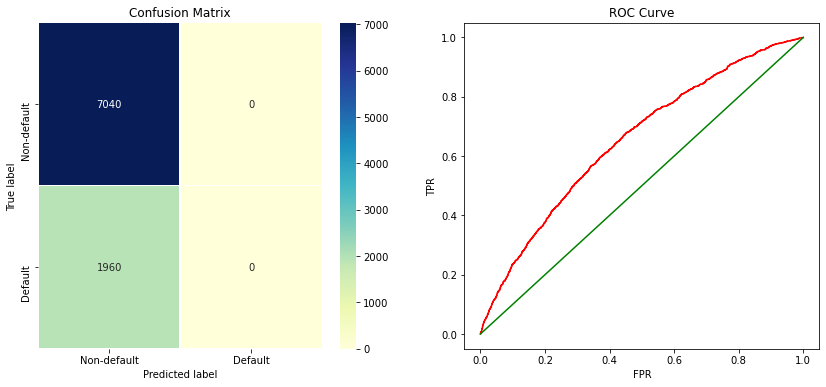

____________________________________________________________
Data is  Over Sampling  And with hyper parameter  {'C': 11787686.347935867}
Overall Train Accuracy 0.6127174712080372
Train AUC Score 0.6427546427822385
Overall Test Accuracy 0.6274444444444445
Test AUC Score 0.6397109809833025
Classification Report of Test
               precision    recall  f1-score   support

           0       0.84      0.65      0.73      7040
           1       0.31      0.56      0.40      1960

    accuracy                           0.63      9000
   macro avg       0.57      0.60      0.56      9000
weighted avg       0.72      0.63      0.66      9000

K-Fold scores: 0.611 (+/- 0.00005)


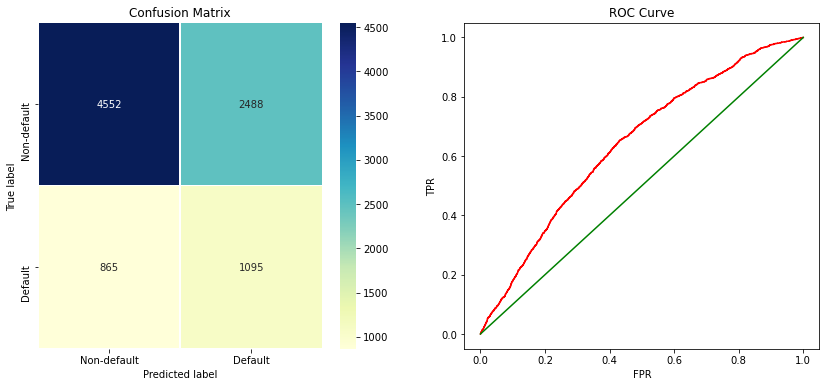

____________________________________________________________
Data is  Under Sampling  And with hyper parameter  {'C': 0.05179474679231213}
Overall Train Accuracy 0.6113130881094953
Train AUC Score 0.6494071386129123
Overall Test Accuracy 0.5598888888888889
Test AUC Score 0.653688978432282
Classification Report of Test
               precision    recall  f1-score   support

           0       0.87      0.52      0.65      7040
           1       0.29      0.71      0.41      1960

    accuracy                           0.56      9000
   macro avg       0.58      0.61      0.53      9000
weighted avg       0.74      0.56      0.60      9000

K-Fold scores: 0.603 (+/- 0.00018)


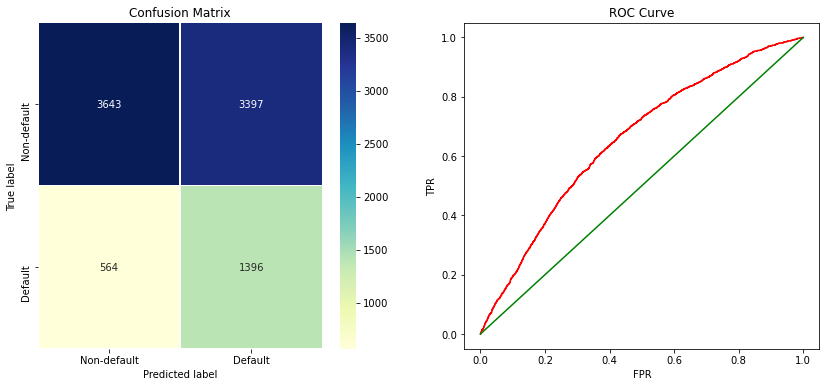

____________________________________________________________
Data is  SMOTE  And with hyper parameter  {'C': 0.0007196856730011522}
Overall Train Accuracy 0.595962999264886
Train AUC Score 0.6538197648229815
Overall Test Accuracy 0.6877777777777778
Test AUC Score 0.643781887755102
Classification Report of Test
               precision    recall  f1-score   support

           0       0.82      0.76      0.79      7040
           1       0.33      0.42      0.37      1960

    accuracy                           0.69      9000
   macro avg       0.58      0.59      0.58      9000
weighted avg       0.72      0.69      0.70      9000

K-Fold scores: 0.592 (+/- 0.00006)


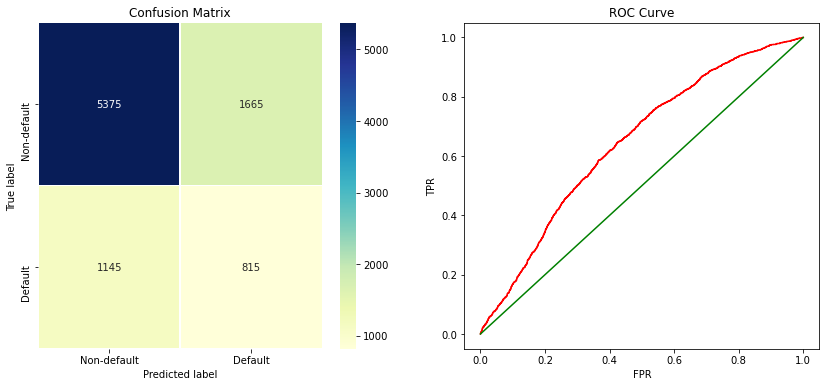

____________________________________________________________


In [38]:
xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']
index = [0,1,2,3]

for i,j,k,l in zip(xtrain_data,ytrain_data,name,index):
    print('Data is ',k,' And with hyper parameter ',param_log[l])
    model_eval(LogisticRegression(**param_log[l],random_state= 42), i,j,X_test,y_test)
    print("_" * 60)
    



### ii) Naive Bayes

Data is  Normal Sampling
Overall Train Accuracy 0.5387619047619048
Train AUC Score 0.7361532579465986
Overall Test Accuracy 0.5334444444444445
Test AUC Score 0.7282000449327458
Classification Report of Test
               precision    recall  f1-score   support

           0       0.89      0.46      0.61      7040
           1       0.29      0.79      0.43      1960

    accuracy                           0.53      9000
   macro avg       0.59      0.63      0.52      9000
weighted avg       0.76      0.53      0.57      9000

K-Fold scores: 0.630 (+/- 0.00097)


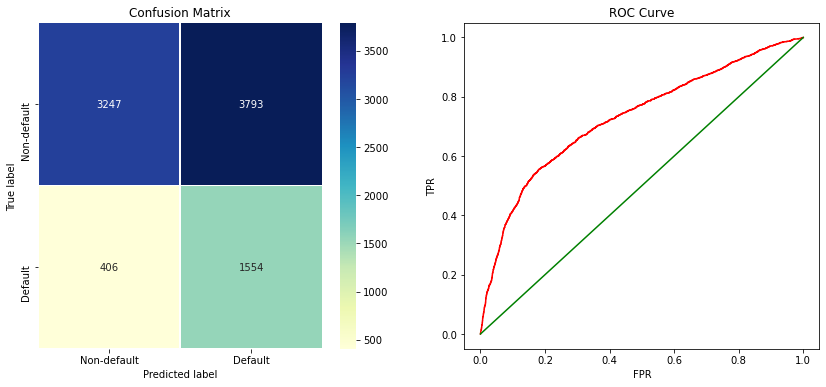

____________________________________________________________
Data is  Over Sampling
Overall Train Accuracy 0.5778608184268562
Train AUC Score 0.7410133663985499
Overall Test Accuracy 0.39211111111111113
Test AUC Score 0.7326445457444342
Classification Report of Test
               precision    recall  f1-score   support

           0       0.90      0.25      0.39      7040
           1       0.25      0.90      0.39      1960

    accuracy                           0.39      9000
   macro avg       0.58      0.58      0.39      9000
weighted avg       0.76      0.39      0.39      9000

K-Fold scores: 0.578 (+/- 0.00002)


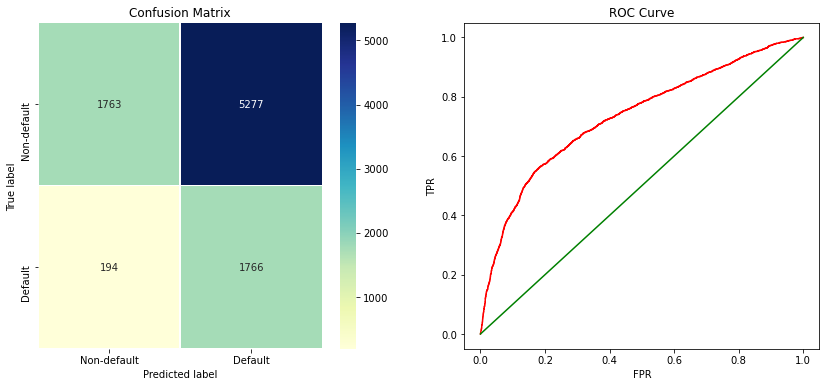

____________________________________________________________
Data is  Under Sampling
Overall Train Accuracy 0.5760265183917879
Train AUC Score 0.7369437999840476
Overall Test Accuracy 0.4081111111111111
Test AUC Score 0.7299100258000927
Classification Report of Test
               precision    recall  f1-score   support

           0       0.90      0.27      0.42      7040
           1       0.25      0.89      0.40      1960

    accuracy                           0.41      9000
   macro avg       0.58      0.58      0.41      9000
weighted avg       0.76      0.41      0.42      9000

K-Fold scores: 0.579 (+/- 0.00012)


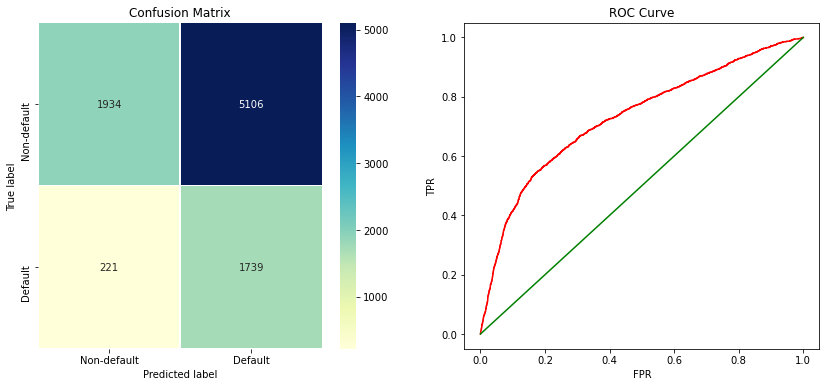

____________________________________________________________
Data is  SMOTE
Overall Train Accuracy 0.5642305807400148
Train AUC Score 0.7862981648090275
Overall Test Accuracy 0.3407777777777778
Test AUC Score 0.7033884725765307
Classification Report of Test
               precision    recall  f1-score   support

           0       0.89      0.18      0.30      7040
           1       0.24      0.92      0.38      1960

    accuracy                           0.34      9000
   macro avg       0.56      0.55      0.34      9000
weighted avg       0.75      0.34      0.32      9000

K-Fold scores: 0.564 (+/- 0.00001)


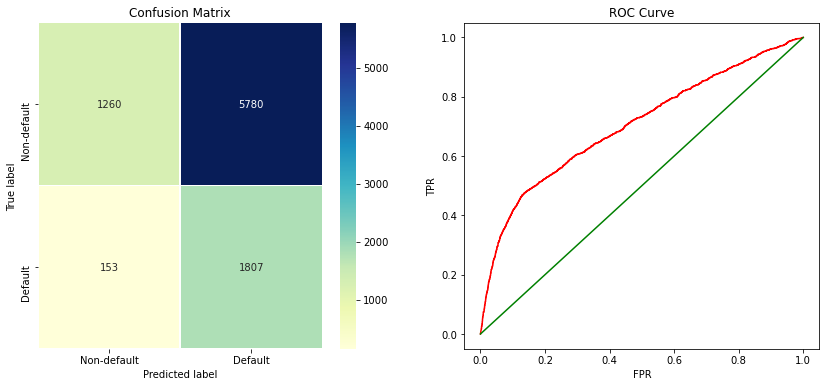

____________________________________________________________


In [39]:
xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']

for i,j,k in zip(xtrain_data,ytrain_data,name):
    print('Data is ',k)
    ss = StandardScaler()
    a = ss.fit_transform(i)
    xts = pd.DataFrame(a,columns = i.columns)
    b = ss.transform(X_test)
    model_eval(GaussianNB(), xts,j,b,y_test)
    print("_" * 60)
    


### iii) K-Nearest Neighbours:

In [36]:
xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']

for i,j,k in zip(xtrain_data,ytrain_data,name):
    global best_xgb
    ss = StandardScaler()
    a = ss.fit_transform(i)
    xts = pd.DataFrame(a,columns = i.columns)
    best_knn = []
    print('Data is ',k) # Instantiate a KNN classifier: tree
    knn = KNeighborsClassifier()
    # Setup the parameters and distributions to sample from: param_dist
    params = {'n_neighbors' : sp_randint(1,20),
             'p': sp_randint(1,5)}
    rsearch_knn = RandomizedSearchCV(knn, param_distributions = params, cv = 3, random_state = 3 , n_iter = 50,n_jobs = -1)
    rsearch_knn.fit(xts,j)
    best_knn.append(rsearch_knn.best_params_)
    print("Tuned KNN Parameters: {}".format(rsearch_knn.best_params_), "for",k)
    print("_" * 100)

Data is  Normal Sampling
Tuned KNN Parameters: {'n_neighbors': 19, 'p': 3} for Normal Sampling
____________________________________________________________________________________________________
Data is  Over Sampling
Tuned KNN Parameters: {'n_neighbors': 1, 'p': 4} for Over Sampling
____________________________________________________________________________________________________
Data is  Under Sampling
Tuned KNN Parameters: {'n_neighbors': 17, 'p': 2} for Under Sampling
____________________________________________________________________________________________________
Data is  SMOTE
Tuned KNN Parameters: {'n_neighbors': 1, 'p': 1} for SMOTE
____________________________________________________________________________________________________


In [37]:
param_knn = [{'n_neighbors': 19, 'p': 3},{'n_neighbors': 1, 'p': 4},{'n_neighbors': 17, 'p': 2},{'n_neighbors': 1, 'p': 1}]

Data is  Normal Sampling  And with hyper parameter  {'n_neighbors': 19, 'p': 3}
Overall Train Accuracy 0.8227619047619048
Train AUC Score 0.8160839686887995
Overall Test Accuracy 0.8082222222222222
Test AUC Score 0.7332581676136364
Classification Report of Test
               precision    recall  f1-score   support

           0       0.83      0.95      0.89      7040
           1       0.62      0.31      0.41      1960

    accuracy                           0.81      9000
   macro avg       0.73      0.63      0.65      9000
weighted avg       0.79      0.81      0.78      9000

K-Fold scores: 0.643 (+/- 0.00008)


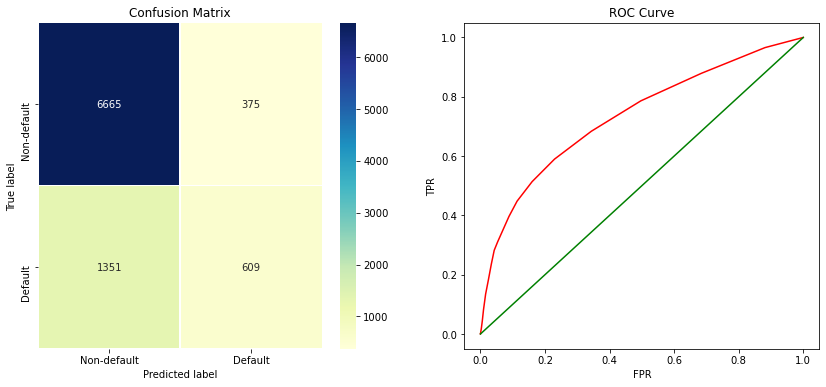

____________________________________________________________
Data is  Over Sampling  And with hyper parameter  {'n_neighbors': 1, 'p': 4}
Overall Train Accuracy 0.9989585885812301
Train AUC Score 0.9989585885812301
Overall Test Accuracy 0.735
Test AUC Score 0.6069544294990723
Classification Report of Test
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      7040
           1       0.39      0.38      0.38      1960

    accuracy                           0.73      9000
   macro avg       0.61      0.61      0.61      9000
weighted avg       0.73      0.73      0.73      9000

K-Fold scores: 0.888 (+/- 0.00002)


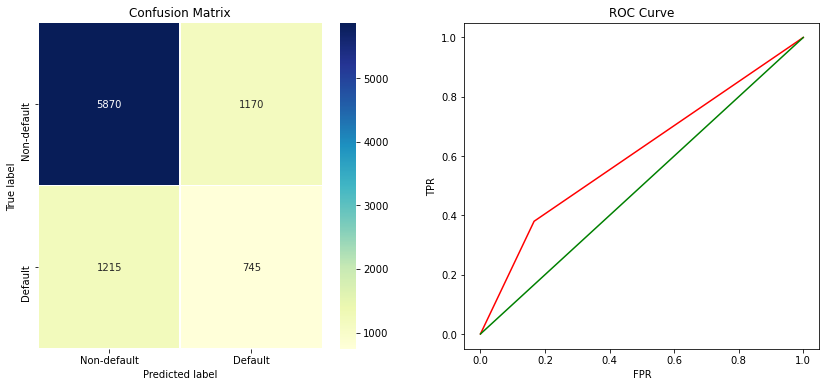

____________________________________________________________
Data is  Under Sampling  And with hyper parameter  {'n_neighbors': 17, 'p': 2}
Overall Train Accuracy 0.7239093242087254
Train AUC Score 0.8038755679402529
Overall Test Accuracy 0.7235555555555555
Test AUC Score 0.7339030974605751
Classification Report of Test
               precision    recall  f1-score   support

           0       0.87      0.76      0.81      7040
           1       0.41      0.59      0.48      1960

    accuracy                           0.72      9000
   macro avg       0.64      0.68      0.65      9000
weighted avg       0.77      0.72      0.74      9000

K-Fold scores: 0.685 (+/- 0.00015)


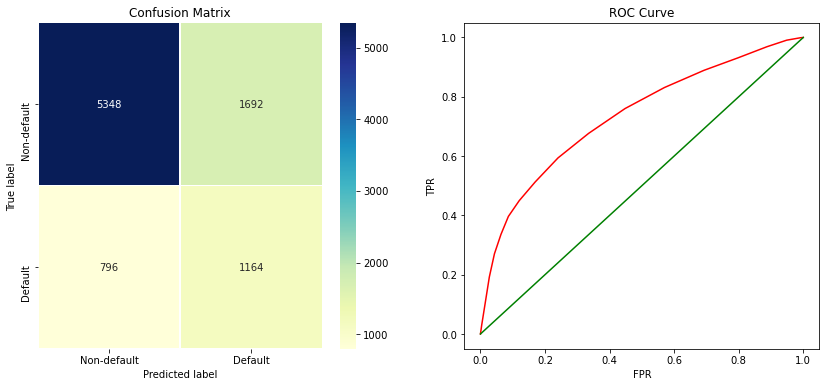

____________________________________________________________
Data is  SMOTE  And with hyper parameter  {'n_neighbors': 1, 'p': 1}
Overall Train Accuracy 0.9991117373192845
Train AUC Score 0.9991117373192845
Overall Test Accuracy 0.6806666666666666
Test AUC Score 0.611617288961039
Classification Report of Test
               precision    recall  f1-score   support

           0       0.84      0.73      0.78      7040
           1       0.34      0.49      0.40      1960

    accuracy                           0.68      9000
   macro avg       0.59      0.61      0.59      9000
weighted avg       0.73      0.68      0.70      9000

K-Fold scores: 0.783 (+/- 0.00000)


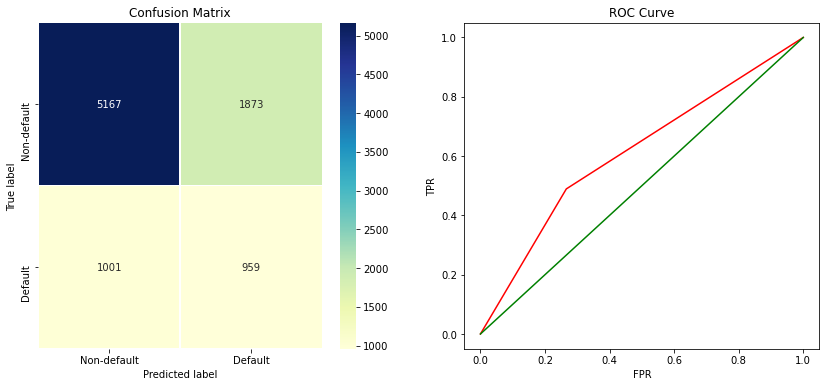

____________________________________________________________


In [39]:
xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']
index = [0,1,2,3]

for i,j,k,l in zip(xtrain_data,ytrain_data,name,index):
    print('Data is ',k,' And with hyper parameter ',param_knn[l])
    ss = StandardScaler()
    a = ss.fit_transform(i)
    xts = pd.DataFrame(a,columns = i.columns)
    b = ss.transform(X_test)
    model_eval(KNeighborsClassifier(**param_knn[l]), xts,j,b,y_test)
    print("_" * 60)
    
    


### iv) Decision Tree

In [40]:
xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']

for i,j,k in zip(xtrain_data,ytrain_data,name):
    print('Data is ',k)
    # Instantiate a Decision Tree classifier: tree
    dtc = DecisionTreeClassifier(random_state = 42)

    # Setup the parameters and distributions to sample from: param_dist
    params = {'max_depth': sp_randint(2,20),
             'min_samples_leaf':sp_randint(1,20),
             'min_samples_split':sp_randint(2,40),
             'criterion':['gini','entropy']}

    # Instantiate the RandomizedSearchCV object: tree_cv
    rsearch_dt = RandomizedSearchCV(dtc, param_distributions= params, cv = 5, scoring = 'roc_auc',n_iter = 100,n_jobs = -1)

    # Fit it to the data
    rsearch_dt.fit(i,j)
    print("Tuned Decision Tree Parameters: {}".format(rsearch_dt.best_params_), "for",name)
    print("_" * 100) 

Data is  Normal Sampling
Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 26} for ['Normal Sampling', 'Over Sampling', 'Under Sampling', 'SMOTE']
____________________________________________________________________________________________________
Data is  Over Sampling
Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 5} for ['Normal Sampling', 'Over Sampling', 'Under Sampling', 'SMOTE']
____________________________________________________________________________________________________
Data is  Under Sampling
Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 27} for ['Normal Sampling', 'Over Sampling', 'Under Sampling', 'SMOTE']
____________________________________________________________________________________________________
Data is  SMOTE
Tuned Decision Tree Parameters: {'criterion': 'gini

In [16]:
param_dt = [{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 26},
           {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 5},
           {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 27},
           {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 19, 'min_samples_split': 11}]

Data is  Normal Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 26}
Overall Train Accuracy 0.8274761904761905
Train AUC Score 0.7749261951470743
Overall Test Accuracy 0.8177777777777778
Test AUC Score 0.7464422686688312
Classification Report of Test
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      7040
           1       0.64      0.37      0.47      1960

    accuracy                           0.82      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000

K-Fold scores: 0.657 (+/- 0.00013)


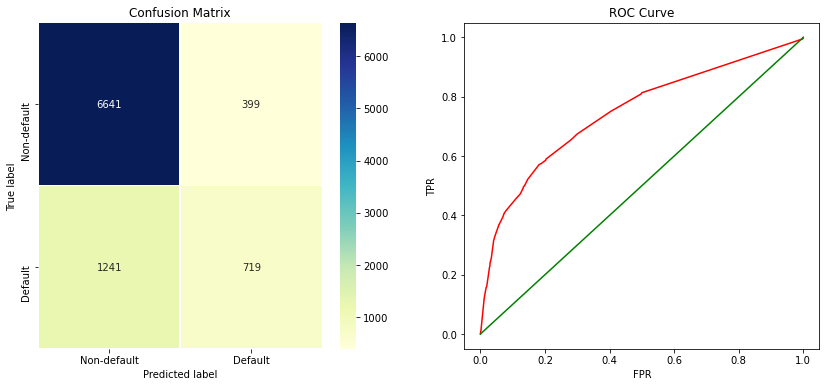

____________________________________________________________
Data is  Over Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 5}
Overall Train Accuracy 0.9328289634893409
Train AUC Score 0.9864134740627507
Overall Test Accuracy 0.707
Test AUC Score 0.6374747796846011
Classification Report of Test
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      7040
           1       0.37      0.49      0.42      1960

    accuracy                           0.71      9000
   macro avg       0.61      0.63      0.61      9000
weighted avg       0.74      0.71      0.72      9000

K-Fold scores: 0.824 (+/- 0.00001)


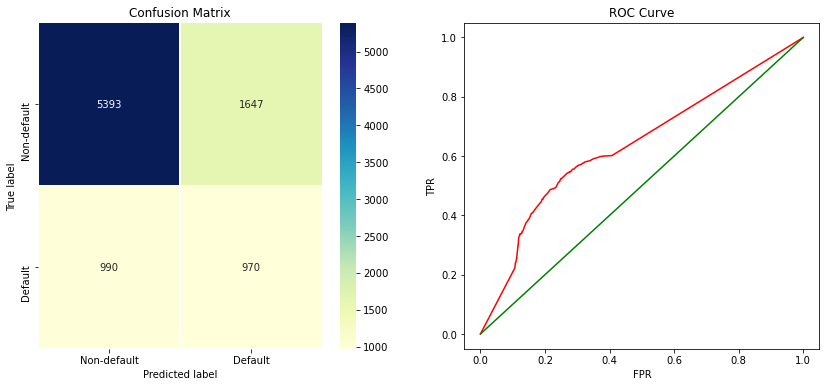

____________________________________________________________
Data is  Under Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 27}
Overall Train Accuracy 0.7214499572284003
Train AUC Score 0.7765852795813725
Overall Test Accuracy 0.7498888888888889
Test AUC Score 0.7469056919642857
Classification Report of Test
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      7040
           1       0.44      0.59      0.51      1960

    accuracy                           0.75      9000
   macro avg       0.66      0.69      0.67      9000
weighted avg       0.78      0.75      0.76      9000

K-Fold scores: 0.699 (+/- 0.00018)


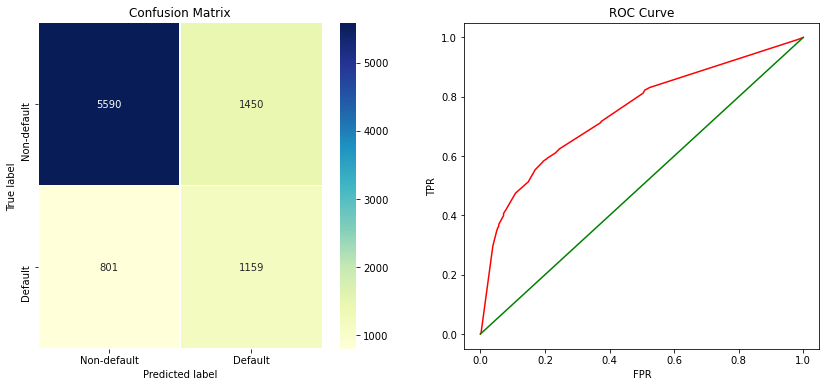

____________________________________________________________
Data is  SMOTE  And with hyper parameter  {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 19, 'min_samples_split': 11}
Overall Train Accuracy 0.8334660622396471
Train AUC Score 0.9241602852065569
Overall Test Accuracy 0.7284444444444444
Test AUC Score 0.7082580589053804
Classification Report of Test
               precision    recall  f1-score   support

           0       0.85      0.79      0.82      7040
           1       0.40      0.51      0.45      1960

    accuracy                           0.73      9000
   macro avg       0.63      0.65      0.64      9000
weighted avg       0.75      0.73      0.74      9000

K-Fold scores: 0.752 (+/- 0.00005)


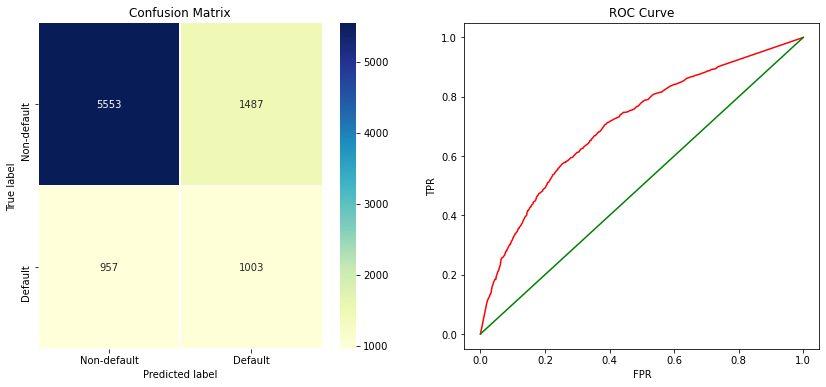

____________________________________________________________


In [17]:
xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']
index = [0,1,2,3]

for i,j,k,l in zip(xtrain_data,ytrain_data,name,index):
    print('Data is ',k,' And with hyper parameter ',param_dt[l])
    model_eval(DecisionTreeClassifier(**param_dt[l],random_state= 42), i,j,X_test,y_test)
    print("_" * 60)
    
    


### v) Random Forest

In [18]:
xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']

for i,j,k in zip(xtrain_data,ytrain_data,name):
    global best_rf
    best_rf =[]
    print('Data is ',k)
    # Instantiate a Random forest classifier: tree
    rfc = RandomForestClassifier(random_state = 42)

    # Setup the parameters and distributions to sample from: param_dist
    params = {'n_estimators' : sp_randint(50,200),
              'max_features' : sp_randint(1,24),'max_depth': sp_randint(2,10),
             'min_samples_leaf':sp_randint(1,20),
             'min_samples_split':sp_randint(2,20),
             'criterion':['gini','entropy']}

    # Instantiate the RandomizedSearchCV object
    rsearch_rfc = RandomizedSearchCV(rfc, param_distributions= params, cv = 5, scoring = 'roc_auc',n_iter = 200,random_state = 42,n_jobs = -1,return_train_score = True)

    # Fit it to the data
    rsearch_rfc.fit(i,j)
    best_rf.append(rsearch_rfc.best_params_)
    print("Tuned Random Tree Parameters: {}".format(rsearch_rfc.best_params_), "for",k)
    print("_" * 100)

Data is  Normal Sampling
Tuned Random Tree Parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 7, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 177} for Normal Sampling
____________________________________________________________________________________________________
Data is  Over Sampling
Tuned Random Tree Parameters: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 22, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 162} for Over Sampling
____________________________________________________________________________________________________
Data is  Under Sampling
Tuned Random Tree Parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 15, 'min_samples_split': 5, 'n_estimators': 125} for Under Sampling
____________________________________________________________________________________________________
Data is  SMOTE
Tuned Random Tree Parameters: {'criterion': 'gini', 'max_depth': 9, 'max_featur

In [19]:
param_rf = [{'criterion': 'entropy', 'max_depth': 9, 'max_features': 7, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 177},
           {'criterion': 'entropy', 'max_depth': 9, 'max_features': 22, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 162},
           {'criterion': 'gini', 'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 15, 'min_samples_split': 5, 'n_estimators': 125},
           {'criterion': 'gini', 'max_depth': 9, 'max_features': 12, 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 58}]

Data is  Normal Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 26}
Overall Train Accuracy 0.8393333333333334
Train AUC Score 0.8363222665531121
Overall Test Accuracy 0.8201111111111111
Test AUC Score 0.7772371796730057
Classification Report of Test
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      7040
           1       0.67      0.35      0.46      1960

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000

K-Fold scores: 0.657 (+/- 0.00009)


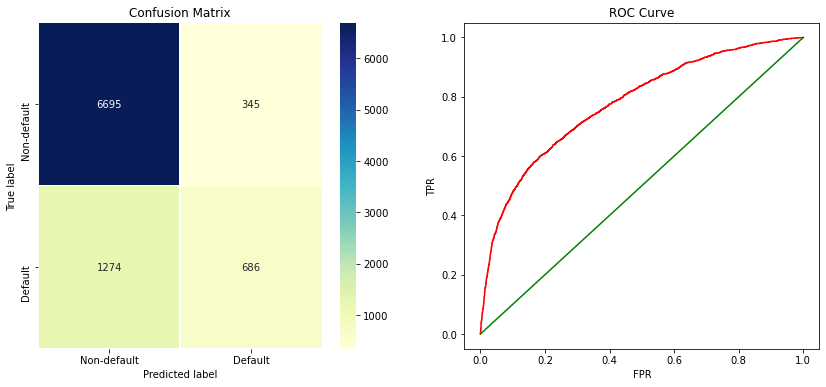

____________________________________________________________
Data is  Over Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 5}
Overall Train Accuracy 0.7847647635383485
Train AUC Score 0.8734712408510797
Overall Test Accuracy 0.7733333333333333
Test AUC Score 0.7755519480519479
Classification Report of Test
               precision    recall  f1-score   support

           0       0.88      0.83      0.85      7040
           1       0.48      0.58      0.53      1960

    accuracy                           0.77      9000
   macro avg       0.68      0.70      0.69      9000
weighted avg       0.79      0.77      0.78      9000

K-Fold scores: 0.757 (+/- 0.00001)


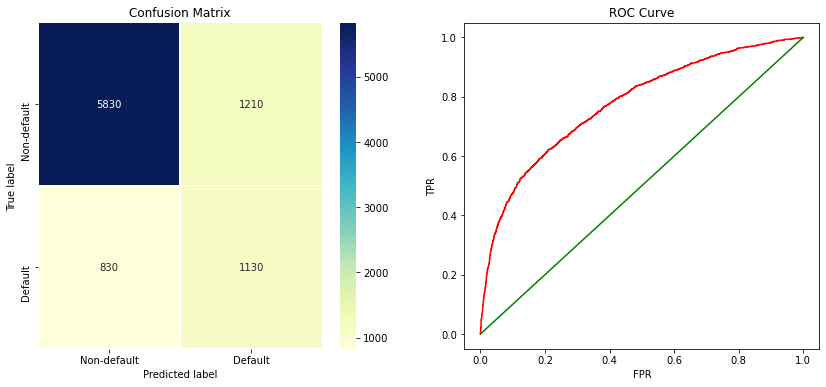

____________________________________________________________
Data is  Under Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 27}
Overall Train Accuracy 0.7501069289991446
Train AUC Score 0.8394782139253206
Overall Test Accuracy 0.7521111111111111
Test AUC Score 0.7732405931122449
Classification Report of Test
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      7040
           1       0.45      0.62      0.52      1960

    accuracy                           0.75      9000
   macro avg       0.67      0.70      0.68      9000
weighted avg       0.79      0.75      0.77      9000

K-Fold scores: 0.718 (+/- 0.00009)


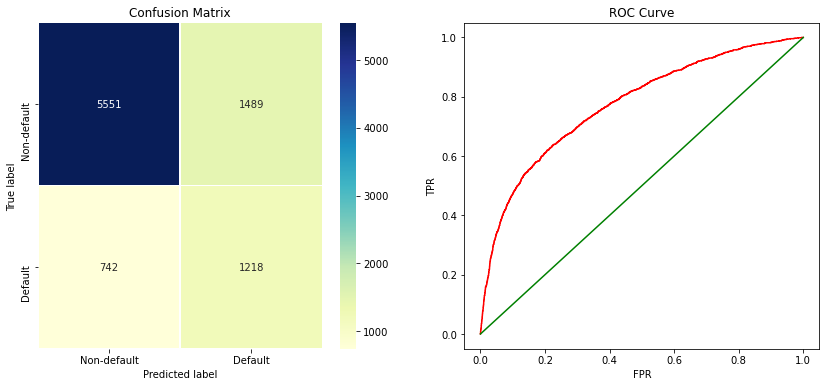

____________________________________________________________
Data is  SMOTE  And with hyper parameter  {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 19, 'min_samples_split': 11}
Overall Train Accuracy 0.8072163685371233
Train AUC Score 0.8934605849112445
Overall Test Accuracy 0.7644444444444445
Test AUC Score 0.7462393465909091
Classification Report of Test
               precision    recall  f1-score   support

           0       0.86      0.83      0.85      7040
           1       0.46      0.53      0.49      1960

    accuracy                           0.76      9000
   macro avg       0.66      0.68      0.67      9000
weighted avg       0.78      0.76      0.77      9000

K-Fold scores: 0.782 (+/- 0.00003)


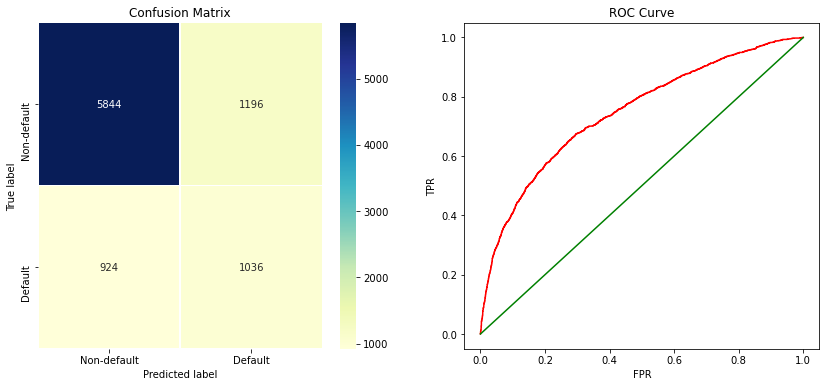

____________________________________________________________


In [20]:
xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']
index = [0,1,2,3]

for i,j,k,l in zip(xtrain_data,ytrain_data,name,index):
    print('Data is ',k,' And with hyper parameter ',param_dt[l])
    model_eval(RandomForestClassifier(**param_rf[l],random_state= 42), i,j,X_test,y_test)
    print("_" * 60)
    


### vi) AdaBoost Classifier

In [40]:
xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']

for i,j,k in zip(xtrain_data,ytrain_data,name):
    global best_ada
    best_ada =[]
    print('Data is ',k)
    # Instantiate a Ada Boost classifier
    ada = AdaBoostClassifier()

    #Creating a grid of hyperparameters
    param_grid = {'n_estimators': [200,300],
                  'algorithm': ['SAMME', 'SAMME.R'],
                  'learning_rate' : [0.5, 0.75, 1.0]}

    #Building a 5 fold CV GridSearchCV object
    grid_ada = GridSearchCV(ada, param_grid, scoring = 'accuracy', cv=5,n_jobs = -1)

    #Fitting the grid to the training data
    grid_ada.fit(i,j)
    best_ada.append(grid_ada.best_params_)
    print("Tuned Ada Boost Parameters: {}".format(grid_ada.best_params_), "for",k)
    print("_" * 100)

Data is  Normal Sampling
Tuned Ada Boost Parameters: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 300} for Normal Sampling
____________________________________________________________________________________________________
Data is  Over Sampling
Tuned Ada Boost Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 300} for Over Sampling
____________________________________________________________________________________________________
Data is  Under Sampling
Tuned Ada Boost Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 300} for Under Sampling
____________________________________________________________________________________________________
Data is  SMOTE
Tuned Ada Boost Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 300} for SMOTE
____________________________________________________________________________________________________


In [41]:
param_ada = [{'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 300},
            {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 300},
            {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 300},
            {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 300}]

Data is  Normal Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 26}
Overall Train Accuracy 0.8201428571428572
Train AUC Score 0.7874794592039012
Overall Test Accuracy 0.8175555555555556
Test AUC Score 0.774499144828386
Classification Report of Test
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      7040
           1       0.67      0.32      0.43      1960

    accuracy                           0.82      9000
   macro avg       0.75      0.64      0.66      9000
weighted avg       0.80      0.82      0.79      9000

K-Fold scores: 0.647 (+/- 0.00013)


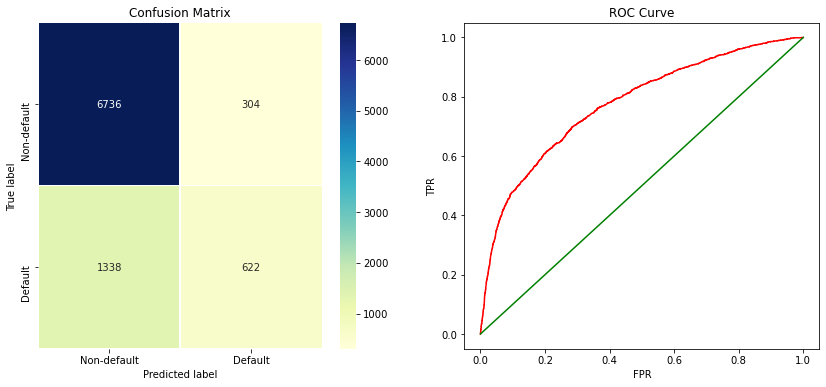

____________________________________________________________
Data is  Over Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 5}
Overall Train Accuracy 0.7288961038961039
Train AUC Score 0.811136332638849
Overall Test Accuracy 0.7474444444444445
Test AUC Score 0.7666669323979591
Classification Report of Test
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      7040
           1       0.44      0.61      0.51      1960

    accuracy                           0.75      9000
   macro avg       0.66      0.70      0.67      9000
weighted avg       0.78      0.75      0.76      9000

K-Fold scores: 0.721 (+/- 0.00003)


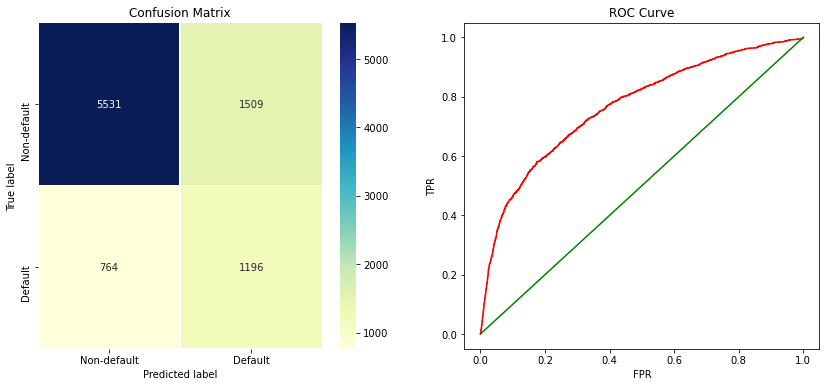

____________________________________________________________
Data is  Under Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 27}
Overall Train Accuracy 0.7342814371257484
Train AUC Score 0.8140721718606049
Overall Test Accuracy 0.7351111111111112
Test AUC Score 0.7608262552179963
Classification Report of Test
               precision    recall  f1-score   support

           0       0.88      0.77      0.82      7040
           1       0.43      0.62      0.51      1960

    accuracy                           0.74      9000
   macro avg       0.65      0.70      0.66      9000
weighted avg       0.78      0.74      0.75      9000

K-Fold scores: 0.702 (+/- 0.00014)


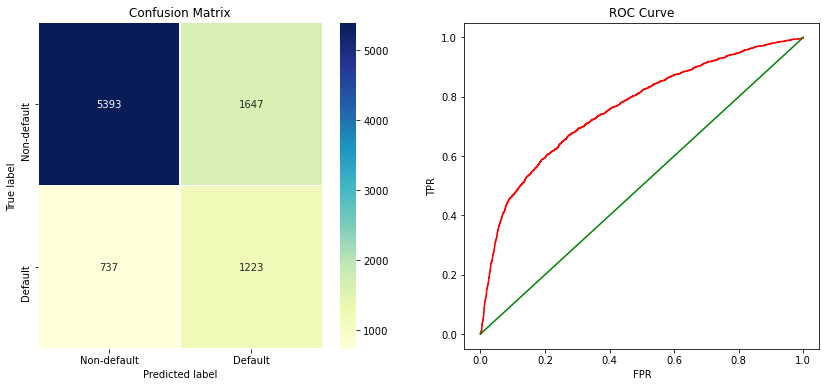

____________________________________________________________
Data is  SMOTE  And with hyper parameter  {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 19, 'min_samples_split': 11}
Overall Train Accuracy 0.8611247243322715
Train AUC Score 0.9250815474811974
Overall Test Accuracy 0.8143333333333334
Test AUC Score 0.7667291859925789
Classification Report of Test
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      7040
           1       0.61      0.40      0.48      1960

    accuracy                           0.81      9000
   macro avg       0.73      0.66      0.68      9000
weighted avg       0.80      0.81      0.80      9000

K-Fold scores: 0.858 (+/- 0.00001)


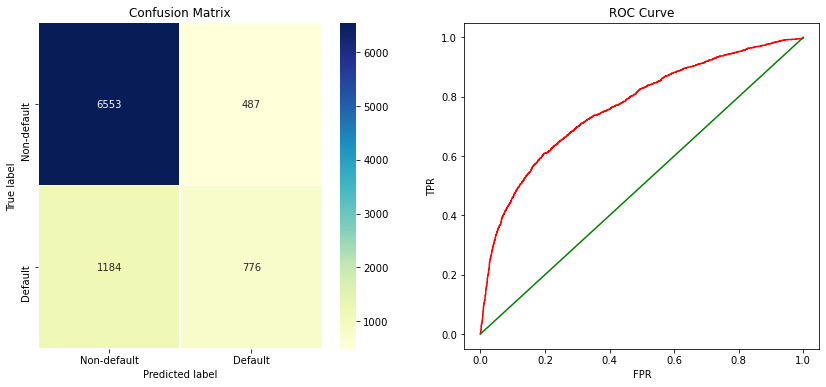

____________________________________________________________


In [42]:
xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']
index = [0,1,2,3]

for i,j,k,l in zip(xtrain_data,ytrain_data,name,index):
    print('Data is ',k,' And with hyper parameter ',param_dt[l])
    model_eval(AdaBoostClassifier(**param_ada[l]), i,j,X_test,y_test)
    print("_" * 60)
    



### vii) GradientBoosting Classifier

In [43]:
xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']

for i,j,k in zip(xtrain_data,ytrain_data,name):
    global best_gbc
    best_gbc =[]
    print('Data is ',k)
    # Instantiate a Gradient Boost classifier
    gbc = GradientBoostingClassifier()

    #Creating a grid of hyperparameters
    param_grid = {'n_estimators': [200,300],
                  'learning_rate' : [0.5, 0.75, 1.0]}

    #Building a 5 fold CV GridSearchCV object
    grid_gbc = GridSearchCV(gbc, param_grid, scoring = 'accuracy', cv=5,n_jobs = -1)

    #Fitting the grid to the training data
    grid_gbc.fit(i,j)
    best_gbc.append(grid_gbc.best_params_)
    print("Tuned Random Tree Parameters: {}".format(grid_gbc.best_params_), "for",k)
    print("_" * 100)

Data is  Normal Sampling
Tuned Random Tree Parameters: {'learning_rate': 0.5, 'n_estimators': 200} for Normal Sampling
____________________________________________________________________________________________________
Data is  Over Sampling
Tuned Random Tree Parameters: {'learning_rate': 1.0, 'n_estimators': 300} for Over Sampling
____________________________________________________________________________________________________
Data is  Under Sampling
Tuned Random Tree Parameters: {'learning_rate': 0.5, 'n_estimators': 200} for Under Sampling
____________________________________________________________________________________________________
Data is  SMOTE
Tuned Random Tree Parameters: {'learning_rate': 0.5, 'n_estimators': 200} for SMOTE
____________________________________________________________________________________________________


In [45]:
param_gbc = [{'learning_rate': 0.5, 'n_estimators': 200},
            {'learning_rate': 1.0, 'n_estimators': 300},
            {'learning_rate': 0.5, 'n_estimators': 200},
            {'learning_rate': 0.5, 'n_estimators': 200}]

Data is  Normal Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 26}
Overall Train Accuracy 0.8670952380952381
Train AUC Score 0.8961920057564012
Overall Test Accuracy 0.8041111111111111
Test AUC Score 0.7547304035250463
Classification Report of Test
               precision    recall  f1-score   support

           0       0.84      0.93      0.88      7040
           1       0.58      0.37      0.45      1960

    accuracy                           0.80      9000
   macro avg       0.71      0.65      0.67      9000
weighted avg       0.78      0.80      0.79      9000

K-Fold scores: 0.660 (+/- 0.00011)


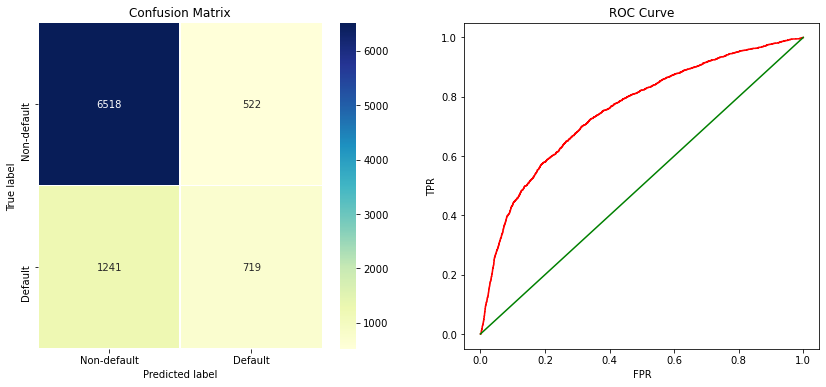

____________________________________________________________
Data is  Over Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 5}
Overall Train Accuracy 0.9015866209262435
Train AUC Score 0.9619559114317092
Overall Test Accuracy 0.734
Test AUC Score 0.716033344445733
Classification Report of Test
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      7040
           1       0.41      0.53      0.46      1960

    accuracy                           0.73      9000
   macro avg       0.64      0.66      0.64      9000
weighted avg       0.76      0.73      0.74      9000

K-Fold scores: 0.825 (+/- 0.00001)


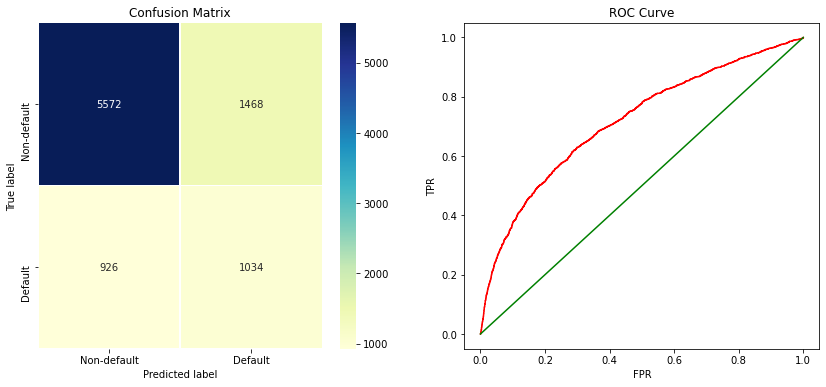

____________________________________________________________
Data is  Under Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 27}
Overall Train Accuracy 0.8588537211291702
Train AUC Score 0.9347821374237959
Overall Test Accuracy 0.7096666666666667
Test AUC Score 0.7462089082792207
Classification Report of Test
               precision    recall  f1-score   support

           0       0.88      0.73      0.80      7040
           1       0.40      0.65      0.49      1960

    accuracy                           0.71      9000
   macro avg       0.64      0.69      0.65      9000
weighted avg       0.78      0.71      0.73      9000

K-Fold scores: 0.683 (+/- 0.00001)


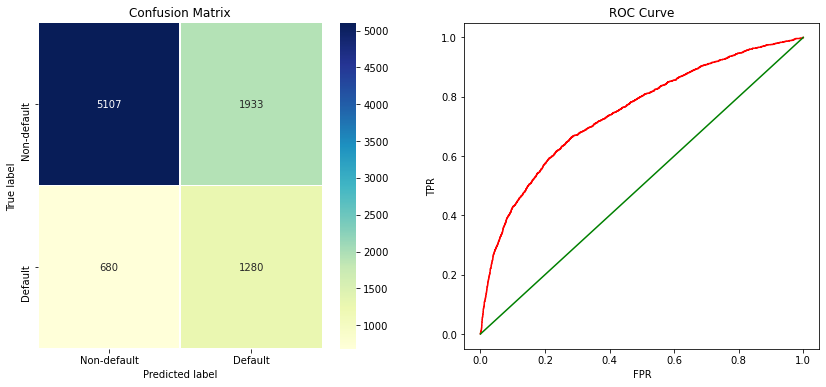

____________________________________________________________
Data is  SMOTE  And with hyper parameter  {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 19, 'min_samples_split': 11}
Overall Train Accuracy 0.8961957853467287
Train AUC Score 0.9613039710263152
Overall Test Accuracy 0.8013333333333333
Test AUC Score 0.751496840213358
Classification Report of Test
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      7040
           1       0.56      0.40      0.47      1960

    accuracy                           0.80      9000
   macro avg       0.70      0.66      0.67      9000
weighted avg       0.78      0.80      0.79      9000

K-Fold scores: 0.860 (+/- 0.00002)


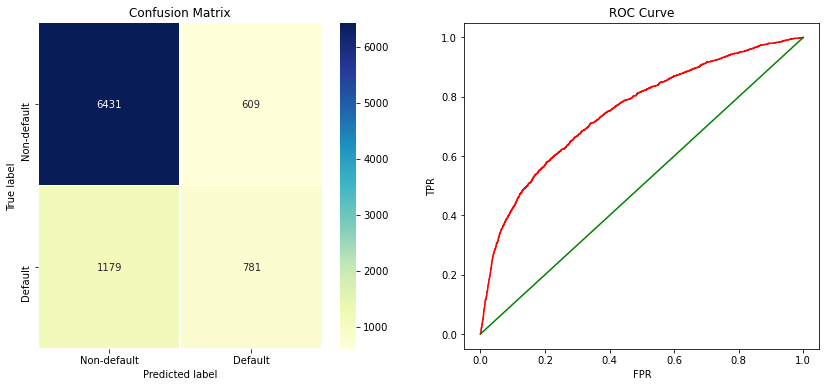

____________________________________________________________


In [46]:
for i,j,k,l in zip(xtrain_data,ytrain_data,name,index):
    print('Data is ',k,' And with hyper parameter ',param_dt[l])
    model_eval(GradientBoostingClassifier(**param_gbc[l]), i,j,X_test,y_test)
    print("_" * 60)
    
    


### viii) XGBoost Classifier

In [44]:
xtrain_data = [X_train,df_upsampled.drop('default_payment',axis = 1),df_downsampled.drop('default_payment',axis = 1),X_SMOTE]
ytrain_data = [y_train,df_upsampled['default_payment'],df_downsampled['default_payment'],y_SMOTE]
name = ['Normal Sampling' , 'Over Sampling' , 'Under Sampling' , 'SMOTE']

for i,j,k in zip(xtrain_data,ytrain_data,name):
    global best_xgb
    best_xgb =[]
    print('Data is ',k)  # Instantiate a XGBoost classifier
    xgb= XGBClassifier()

    param_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
                  "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
                 "min_child_weight" : [1, 3, 5, 7],
                 "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
                 "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7] }

    #Building a 5 fold CV GridSearchCV object
    xgb_RS = RandomizedSearchCV(xgb, param_grid ,cv = 5, scoring = 'roc_auc',n_iter = 200,n_jobs = -1)

    #Fitting the grid to the training data
    xgb_RS.fit(i,j)
    best_xgb.append(xgb_RS.best_params_)
    print("Tuned XG Boost Parameters: {}".format(xgb_RS.best_params_), "for",k)
    print("_" * 100)

Data is  Normal Sampling
[13:04:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Tuned XG Boost Parameters: {'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.4} for Normal Sampling
____________________________________________________________________________________________________
Data is  Over Sampling
[13:31:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Tuned XG Boost Parameters: {'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.2, 'colsample_bytree': 0.3} for Over 

In [47]:
param_xgb = [{'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.05,
                            'gamma': 0.4, 'colsample_bytree': 0.4},
            {'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.3,
                            'gamma': 0.2, 'colsample_bytree': 0.3},
            {'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05,
                            'gamma': 0.0, 'colsample_bytree': 0.3},
            {'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.1,
                            'gamma': 0.2, 'colsample_bytree': 0.4}]

Data is  Normal Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 26}
[14:17:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Overall Train Accuracy 0.8386190476190476
Train AUC Score 0.8353579731879399
Overall Test Accuracy 0.8191111111111111
Test AUC Score 0.7793609766349722
Classification Report of Test
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      7040
           1       0.66      0.35      0.46      1960

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.67      9000
weighted avg       0.80      0.82      0.80      9000

[14:17:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:10

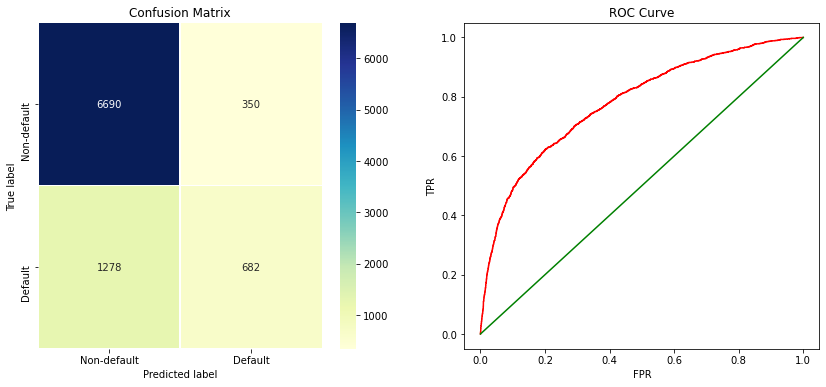

____________________________________________________________
Data is  Over Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 5}
[14:17:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Overall Train Accuracy 0.9971820632197991
Train AUC Score 0.9999680211474803
Overall Test Accuracy 0.7987777777777778
Test AUC Score 0.7439395147263451
Classification Report of Test
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      7040
           1       0.55      0.41      0.47      1960

    accuracy                           0.80      9000
   macro avg       0.70      0.66      0.67      9000
weighted avg       0.78      0.80      0.79      9000

[14:17:26] 

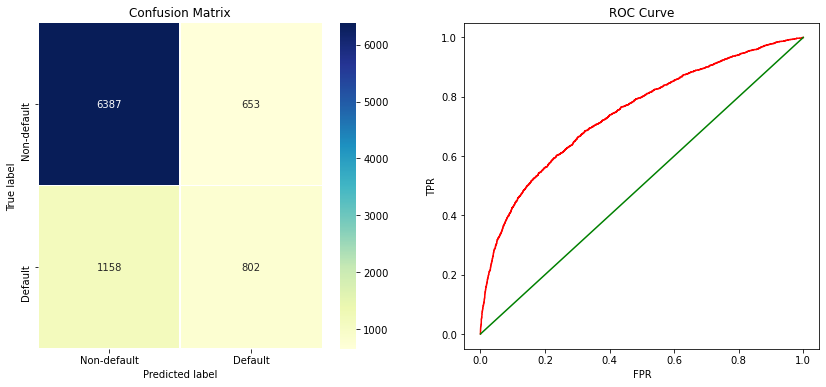

____________________________________________________________
Data is  Under Sampling  And with hyper parameter  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 27}
[14:17:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Overall Train Accuracy 0.7340675791274593
Train AUC Score 0.8123092382996441
Overall Test Accuracy 0.7535555555555555
Test AUC Score 0.7764540453965678
Classification Report of Test
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      7040
           1       0.45      0.63      0.53      1960

    accuracy                           0.75      9000
   macro avg       0.67      0.71      0.68      9000
weighted avg       0.79      0.75      0.77      9000

[14:17:40

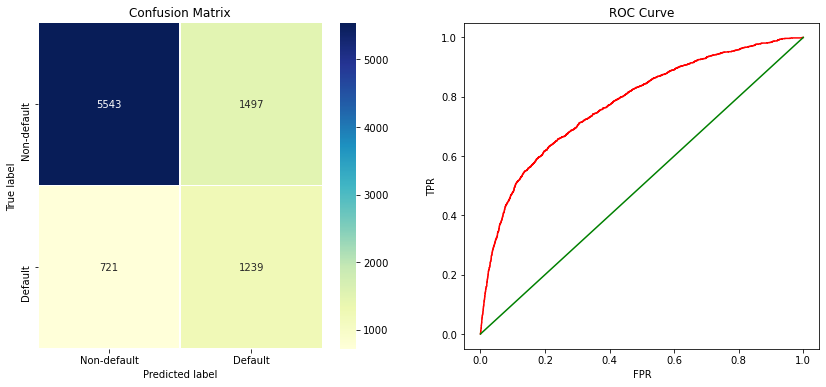

____________________________________________________________
Data is  SMOTE  And with hyper parameter  {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 19, 'min_samples_split': 11}
[14:17:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Overall Train Accuracy 0.99721269296741
Train AUC Score 0.999969173234287
Overall Test Accuracy 0.8044444444444444
Test AUC Score 0.7531887030380334
Classification Report of Test
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      7040
           1       0.58      0.39      0.47      1960

    accuracy                           0.80      9000
   macro avg       0.71      0.66      0.67      9000
weighted avg       0.79      0.80      0.79      9000

[14:17:47] WARNIN

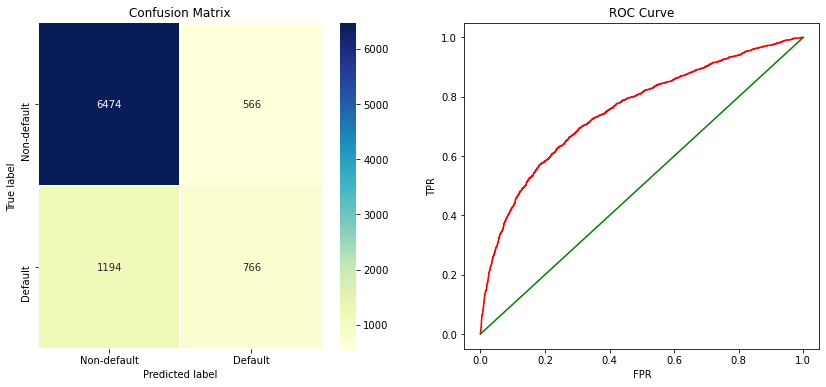

____________________________________________________________


In [48]:
for i,j,k,l in zip(xtrain_data,ytrain_data,name,index):
    print('Data is ',k,' And with hyper parameter ',param_dt[l])
    model_eval(XGBClassifier(**param_xgb[l]), i,j,X_test,y_test)
    print("_" * 60)
    
    

In [49]:
# create a function to see the feature importance of model

def plot_Feature(feature, clf):
    tmp = pd.DataFrame({'Feature': feature, 
                        'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    fig = go.Figure(go.Bar(
    x=tmp['Feature'],y=tmp['Feature importance'],marker={'color': tmp['Feature importance'], 
    'colorscale': 'Viridis'}
    ))
    fig.update_layout(title_text='Feature Importance',xaxis_title="Feature",yaxis_title="Importance")
    return fig.show()

In [52]:
# Choose one model

param_r = {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 300}
rfc_s = AdaBoostClassifier(**param_r,random_state = 42).fit(X_SMOTE,y_SMOTE)

In [53]:
plot_Feature(X_SMOTE.columns,rfc_s)